# 1. 문제 정의 및 데이터 선정 이유

**문제 상황 가정**<br>
1인 앱 기업의 창업자 박찬욱은 자신의 머신러닝 기술을 이용해 직접 앱을 개발해보려 한다.<br>
한편, 아직 회사의 규모가 크지 않고 인지도가 낮다는 점을 생각하여,유저들에게 어필할 수 있는 앱을 생각해 낸 결과<br>
찬욱은 자신의 취미인 경마를 이용하여 같은 경마 동호회 사람들에게 어필할 수 있는 경마 승패 예측 앱을 만들려고 결정하였다.<br>
이를 이용하면 경마라는 상대적으로 마이너하지만 경쟁자가 없는 시장을 공략함으로서 앱 회사의 인지율을 높일 수 있을 것이다.




**문제 설정**<br>
두 말의 정보를 가지고 어떤 말이 이길지를 계산하는 이진분류를 예측하는 모델을 만든다.<br>
최소한의 베이스라인은 '가장 현재 등급이 높은 말이 우승한다.'를 가정으로 만들어,<br>베이스라인의 예측력을 넘는 어느정도 예측력이 있는 모델을 목표로 한다고 하자.
<br>
경기에 출전하는 말들에 대해 2개의 말을 짝지을 수 있는 모든 조합에 대해 모델을 이용해 승패를 예상 한 후,<br>
결과를 조합하여 등수를 예상할 수 있다.

**사용하는 데이터의 출처와 범위**<br>
공공데이터포털의 한국마사회에서 제출한 OpenAPI 데이터와<br>
한국마사회 사이트의 경주마 명단, 기수 프로필, 조교사 프로필을 참고한다.

모든 데이터는 서울에서 개최되는 경마에만 이용된다. 따라서 지역은 
또한 현역 경주마에 대해 데이터를 사용할 예정이므로, 말 이름을 columns로 가진 데이터셋은 현역경주마에 대한 데이터만 사용할 것이다.

**가설**

*   경주마의 체중이 가벼울수록 승률이 높아진다.
*   수컷인 경우 암말과 거세한 말에 비해 승률이 높아진다.
*   국산마보다 외산마가 더 승률이 높다.
*   나이가 어릴수록 승률이 높아진다.
*   품평회에서 좋은 성적을 얻을수록 승률이 높아진다.


# 2. 데이터 전처리, EDA, 시각화

## import

In [ ]:
!python -m pip uninstall matplotlib --y
!pip install matplotlib

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.4 MB 4.8 MB/s 
     |████████████████████████████████| 965 kB 75.4 MB/s 
     |████████████████████████████████| 295 kB 89.2 MB/s 


In [ ]:
import seaborn as sns

In [ ]:
!pip install networkx --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.7 MB/s 
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3


In [ ]:
import pandas as pd
!pip uninstall -y pandas-profiling
!pip3 install pandas_profiling
from pandas_profiling import ProfileReport
import os
import numpy as np

import warnings
warnings.filterwarnings(action='ignore') 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

Found existing installation: pandas-profiling 3.5.0
Uninstalling pandas-profiling-3.5.0:
  Successfully uninstalled pandas-profiling-3.5.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandas_profiling-3.5.0-py2.py3-none-any.whl (325 kB)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

## 경주마 프로필 데이터

In [ ]:
files= os.listdir("/content")
files=[i for i in files if '경주마프로필_' in i]
files.sort()
hr_pf = pd.DataFrame()
for file in files:
  df=pd.read_excel(file)
  hr_pf = pd.concat([hr_pf, df], ignore_index=True)

In [ ]:
hr_pf.head()

순     마명   레이팅1   레이팅2   레이팅3   레이팅4   조  등급  산지 성별  연령          전적  \
0  1.0    강토마  115.0  116.0  116.0  116.0  10  국1  한국  거   7  36(10/8/2)   
1  2.0   갤럽컬린   84.0   84.0   81.0   81.0  34  외1  미국  거   6   24(5/2/4)   
2  3.0     고업   82.0   82.0   73.0   66.0  13  국1  한국  암   5   16(5/5/0)   
3  4.0    굿필승   91.0   91.0   91.0   89.0   4  외1  미국  수   4   14(5/4/1)   
4  5.0  글로벌캡틴  110.0  112.0  113.0  114.0  10  외1  미국  수   6   27(8/1/3)   

           수득상금(천원)           최근출전일 비고 육성조련심사 합격여부 퇴역자마 여부 경매마 여부  
0           649,000  2022/11/20-11R              Y       Y      Y  
1           267,430  2022/08/28-10R              N       N      N  
2           323,710  2022/11/06-11R  차           Y       N      Y  
3           258,680  2022/11/20-11R              N       N      N  
4           560,050  2022/11/06-11R  금           N       N      N

In [ ]:
hr_pf = hr_pf.drop(['순','조','최근출전일','레이팅3','레이팅4','비고'], axis = 1)

In [ ]:
hr_pf = hr_pf[(hr_pf['육성조련심사 합격여부'] == 'Y') | (hr_pf['산지'] != '한국')]

In [ ]:
hr_pf = hr_pf.drop(['육성조련심사 합격여부','퇴역자마 여부'], axis = 1)

In [ ]:
hr_pf.isna().sum()

마명            0
레이팅1        508
레이팅2        551
등급            0
산지            0
성별            0
연령            0
전적            0
수득상금(천원)      0
경매마 여부        0
dtype: int64

In [ ]:
hr_pf = hr_pf.fillna(0)

In [ ]:
hr_pf.등급 =  hr_pf.등급.apply(lambda x : x.replace('국','').replace('외','').replace('미검','7')).astype(int)

In [ ]:
hr_pf[['총_출전수', '전적']] = hr_pf['전적'].str.split('(', 1, expand=True)

In [ ]:
hr_pf[['1위 횟수', '2위 횟수', '3위 횟수']] = hr_pf['전적'].str.split('/', 2, expand=True)

In [ ]:
hr_pf['3위 횟수'] = hr_pf['3위 횟수'].apply(lambda x : x.replace(')',''))

In [ ]:
hr_pf = hr_pf.drop(['전적'], axis = 1)

In [ ]:
hr_pf.head()

마명   레이팅1   레이팅2  등급  산지 성별  연령          수득상금(천원) 경매마 여부 총_출전수 1위 횟수  \
0    강토마  115.0  116.0   1  한국  거   7           649,000      Y    36    10   
1   갤럽컬린   84.0   84.0   1  미국  거   6           267,430      N    24     5   
2     고업   82.0   82.0   1  한국  암   5           323,710      Y    16     5   
3    굿필승   91.0   91.0   1  미국  수   4           258,680      N    14     5   
4  글로벌캡틴  110.0  112.0   1  미국  수   6           560,050      N    27     8   

  2위 횟수 3위 횟수  
0     8     2  
1     2     4  
2     5     0  
3     4     1  
4     1     3

In [ ]:
hr_pf.dtypes

마명           object
레이팅1        float64
레이팅2        float64
등급            int64
산지           object
성별           object
연령            int64
수득상금(천원)     object
경매마 여부       object
총_출전수        object
1위 횟수        object
2위 횟수        object
3위 횟수        object
dtype: object

In [ ]:
hr_pf['수득상금(천원)'] = hr_pf['수득상금(천원)'].apply(lambda x : str(x).replace(' ','').replace(',',''))

In [ ]:
for col in ['레이팅1', '레이팅2', '수득상금(천원)', '총_출전수', '1위 횟수', '2위 횟수', '3위 횟수']:
  hr_pf[col] = hr_pf[col].astype(int)

In [ ]:
hr_pf['수득상금(천원)'] = hr_pf['수득상금(천원)']/hr_pf['총_출전수']
hr_pf['수득상금(천원)'] = hr_pf['수득상금(천원)'].fillna(0)

In [ ]:
hr_pf['수득상금(천원)'] = hr_pf['수득상금(천원)'].apply(lambda x : round(x))

In [ ]:
hr_pf

마명  레이팅1  레이팅2  등급  산지 성별  연령  수득상금(천원) 경매마 여부  총_출전수  1위 횟수  2위 횟수  \
0        강토마   115   116   1  한국  거   7     18028      Y     36     10      8   
1       갤럽컬린    84    84   1  미국  거   6     11143      N     24      5      2   
2         고업    82    82   1  한국  암   5     20232      Y     16      5      5   
3        굿필승    91    91   1  미국  수   4     18477      N     14      5      4   
4      글로벌캡틴   110   112   1  미국  수   6     20743      N     27      8      1   
...      ...   ...   ...  ..  .. ..  ..       ...    ...    ...    ...    ...   
1635    해제여걸     0     0   7  한국  암   2         0      N      0      0      0   
1636    해피고고     0     0   7  한국  암   2         0      N      0      0      0   
1638  화이트다이아     0     0   7  한국  암   2         0      Y      0      0      0   
1640   히어로최강     0     0   7  한국  암   2         0      Y      0      0      0   
1641   히어로파크     0     0   7  한국  거   2         0      Y      0      0      0   

      3위 횟수  
0         2  
1         4  
2         0  
3         1  
4         3  
...     ...  
1635      0  
1636      0  
1638      0  
1640      0  
1641      0  

[1289 rows x 13 columns]

## 기수 프로필 데이터 & 조교사 프로필 데이터

In [ ]:
jk_pf = pd.read_excel('/content/기수프로필.xlsx')

In [ ]:
jk_pf.head()

기수명    1위    2위    3위    총출전    승률   복승률
0  박태종  2193  2028  1721  15157  14.5  27.8
1  문세영  1798  1333  1024   8501  21.2  36.8
2  최범현   871   822   733   6950  12.5  24.4
3  김용근   846   704   609   5443  15.5  28.5
4  함완식   795   810   736   6272  12.7  25.6

In [ ]:
tr_pf = pd.read_excel('/content/조교사프로필.xlsx')

In [ ]:
tr_pf.head()

조교사명   1위   2위   3위  총 출전    승률   복승률
0  배대선  872  841  827  7920  11.0  21.6
1  이희영  679  743  761  8494   8.0  16.7
2  정호익  537  554  539  5248  10.2  20.8
3  박종곤  516  451  466  4839  10.7  20.0
4  곽영효  505  480  424  4849  10.4  20.3

## 경주성적정보

In [ ]:
RaceDetailResult = pd.read_csv("/content/drive/MyDrive/제목없는 폴더/경주성적정보.csv")

In [ ]:
RaceDetailResult.shape

(837688, 63)

In [ ]:
rename2 = pd.read_csv("/content/rename2.csv")

In [ ]:
rename = dict(zip(rename2['항목명(영문)'], rename2['항목명(국문)']))
RaceDetailResult = RaceDetailResult.rename(rename, axis=1)
rename1 = pd.read_csv("rename1.csv")
rename = dict(zip(rename1.colname1, rename1.colname2))
RaceDetailResult = RaceDetailResult.rename(rename, axis=1)

In [ ]:
RaceDetailResult = RaceDetailResult[~RaceDetailResult.마명.isna()]
RaceDetailResult.마명 = RaceDetailResult.마명.apply(lambda x : x.replace('[부산경남]','').replace('[서울]',''))

In [ ]:
RaceDetailResult = RaceDetailResult[RaceDetailResult.마명.isin(hr_pf.마명)]

In [ ]:
RaceDetailResult

연령        생년월일 부담구분      부가상금1      부가상금2     부가상금3         1착상금  \
273      2  19820802.0   마령        0.0        0.0       0.0          0.0   
6147     2  19820910.0   마령        0.0        0.0       0.0          0.0   
7016     2  19820910.0   마령        0.0        0.0       0.0          0.0   
7781     2  19820910.0   마령        0.0        0.0       0.0          0.0   
8789     3  19820910.0   마령        0.0        0.0       0.0          0.0   
...     ..         ...  ...        ...        ...       ...          ...   
837087   4  20180430.0  별정A  5832000.0  2916000.0  972000.0  247500000.0   
837093   4  20180303.0  별정A  5832000.0  2916000.0  972000.0  247500000.0   
837094   5  20170320.0  별정A  5832000.0  2916000.0  972000.0  247500000.0   
837095   6  20160507.0  별정A  5832000.0  2916000.0  972000.0  247500000.0   
837098   6  20160306.0  별정A  5832000.0  2916000.0  972000.0  247500000.0   

              2착상금        3착상금        4착상금  ...  단승식배당율   날씨  연령조건    경주조건  \
273            0.0         0.0         0.0  ...     0.0   맑음   NaN     NaN   
6147           0.0         0.0         0.0  ...     0.0   맑음   NaN     NaN   
7016           0.0         0.0         0.0  ...     0.0  NaN   NaN     NaN   
7781           0.0         0.0         0.0  ...     0.0   맑음   NaN     NaN   
8789           0.0         0.0         0.0  ...     0.0    비   NaN     NaN   
...            ...         ...         ...  ...     ...  ...   ...     ...   
837087  99000000.0  63000000.0  22500000.0  ...   131.2   흐림  3세이상  R0~140   
837093  99000000.0  63000000.0  22500000.0  ...   133.0   흐림  3세이상  R0~140   
837094  99000000.0  63000000.0  22500000.0  ...    21.8   흐림  3세이상  R0~140   
837095  99000000.0  63000000.0  22500000.0  ...    47.1   흐림  3세이상  R0~140   
837098  99000000.0  63000000.0  22500000.0  ...   156.6   흐림  3세이상  R0~140   

        G4F(부경)_3C(서울,제주) G6F(부경)_2C(서울,제주)  G8F(부경)_1C(서울,제주)  S1F순위 S1F기록  \
273                   NaN               NaN                NaN    NaN   NaN   
6147                  NaN               NaN                NaN    NaN   NaN   
7016                  NaN               NaN                NaN    NaN   NaN   
7781                  NaN               NaN                NaN    NaN   NaN   
8789                  NaN               NaN                NaN    NaN   NaN   
...                   ...               ...                ...    ...   ...   
837087               12.0              13.0               12.0   12.0  14.2   
837093               16.0              16.0               16.0   16.0  15.0   
837094               14.0              15.0               15.0   15.0  14.9   
837095                9.0              10.0                7.0    6.0  14.0   
837098               13.0               7.0                8.0    7.0  14.1   

            장구내역  
273          NaN  
6147         NaN  
7016         NaN  
7781         NaN  
8789         NaN  
...          ...  
837087   망사,승인편자  
837093  계란형큰,망사눈  
837094   계란형큰,망사  
837095  망사눈,승인편자  
837098  망사눈,반가지큰  

[13895 rows x 63 columns]

In [ ]:
RaceDetailResult.생년월일 = pd.to_datetime(RaceDetailResult.생년월일.astype(str), format=('%Y%m%d.0'))
RaceDetailResult = RaceDetailResult[RaceDetailResult['생년월일']==RaceDetailResult.groupby('마명')['생년월일'].transform(max)]

In [ ]:
RaceDetailResult = RaceDetailResult[RaceDetailResult['생년월일'] + pd.to_timedelta(RaceDetailResult['연령']*365, 'D') > pd.to_datetime('2021-01-01')]

In [ ]:
RaceDetailResult.기수번호 = RaceDetailResult.기수번호.astype(int)

In [ ]:
RaceDetailResult = RaceDetailResult[RaceDetailResult.경마장명 == '서울']

In [ ]:
RaceDetailResult.경주일자 = pd.to_datetime(RaceDetailResult.경주일자.astype(str), format=('%Y%m%d'))

In [ ]:
RaceDetailResult = RaceDetailResult[['연령', '부담구분', '1착상금', '2착상금', '3착상금', '출전번호', '마명', '기수명', '마필생산국가', 
                                     '순위', '등급조건', '경주일자', '경주거리', '경주번호', '성별', '조교사명','주로', 
                                     '부담중량', '마체감량', '날씨', '경주조건']]

In [ ]:
RaceDetailResult.주로 = RaceDetailResult.주로.apply(lambda x: int(x.split('(')[1].split('%')[0])*0.01)

In [ ]:
RaceDetailResult.마체감량 = RaceDetailResult.마체감량.apply(lambda x: x.split('(')[0]).astype(int)

In [ ]:
RaceDetailResult = RaceDetailResult.merge(hr_pf, how = 'left', on = '마명', suffixes=('', '_y'))

In [ ]:
RaceDetailResult = RaceDetailResult.merge(jk_pf, how = 'left', on = '기수명', suffixes=('', '_기수'))
RaceDetailResult.drop(RaceDetailResult.filter(regex='_y$').columns, axis=1, inplace=True)

In [ ]:
RaceDetailResult = RaceDetailResult.merge(tr_pf, how = 'left', on = '조교사명', suffixes=('', '_조교사'))
RaceDetailResult.drop(RaceDetailResult.filter(regex='_y$').columns, axis=1, inplace=True)

In [ ]:
RaceDetailResult = RaceDetailResult[RaceDetailResult.기수명.isin(jk_pf.기수명)]
RaceDetailResult = RaceDetailResult[RaceDetailResult.조교사명.isin(tr_pf.조교사명)]

In [ ]:
RaceDetailResult = RaceDetailResult.rename({'총_출전수':'총출전_경주마','1위 횟수':'1위_경주마','2위 횟수':'2위_경주마','3위 횟수':'3위_경주마', '1위' : '1위_기수', '2위' : '2위_기수', '3위' : '3위_기수', '총출전':'총출전_기수', '승률' : '승률_기수', '복승률':'복승률_기수', '총 출전':'총출전_조교사'}, axis=1)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
RaceDetailResult

연령 부담구분        1착상금        2착상금        3착상금 출전번호      마명   기수명 마필생산국가  \
0       3  별정A   8800000.0   5500000.0   3740000.0    1    농본바다   김효정     한국   
2       3  별정A   8800000.0   5500000.0   3740000.0    9    머니스톤   임다빈     한국   
3       3  별정A   8800000.0   5500000.0   3740000.0    2  이스트임팩트  안토니오     한국   
4       3  별정A   8800000.0   5500000.0   3740000.0   10     대완구   김효정     한국   
5       3  별정A   8800000.0   5500000.0   3740000.0    8  스위트주스바   박을운     한국   
...    ..  ...         ...         ...         ...  ...     ...   ...    ...   
10042   5  핸디캡  41250000.0  16500000.0  10500000.0    2      검포   오수철     한국   
10043   4  핸디캡  41250000.0  16500000.0  10500000.0    7     터프맨   장추열     한국   
10044   5  핸디캡  41250000.0  16500000.0  10500000.0    8   에이투제트    이혁     한국   
10045   7  핸디캡  41250000.0  16500000.0  10500000.0   11   제주의흑선   김동수     한국   
10046   6  핸디캡  41250000.0  16500000.0  10500000.0    3   화이트코멧   이동하     한국   

       순위  등급조건       경주일자    경주거리  경주번호 성별 조교사명    주로  부담중량  마체감량  날씨   경주조건  \
0       3  국6등급 2021-01-29  1000.0     1  암  배대선  0.11  54.5   475  맑음   R0~0   
2      10  국6등급 2021-01-29  1000.0     1  암  김동균  0.11  51.5   415  맑음   R0~0   
3       1  국6등급 2021-01-29  1200.0     2  거  박재우  0.11  56.5   447  맑음   R0~0   
4       3  국6등급 2021-01-29  1200.0     2  거  배대선  0.11  56.5   435  맑음   R0~0   
5       4  국6등급 2021-01-29  1200.0     2  수  이신영  0.11  56.5   531  맑음   R0~0   
...    ..   ...        ...     ...   ... ..  ...   ...   ...   ...  ..    ...   
10042   7  국3등급 2022-11-05  1400.0    10  수  박병일  0.04  54.0   491  맑음  R1~65   
10043   8  국3등급 2022-11-05  1400.0    10  거  정호익  0.04  53.0   512  맑음  R1~65   
10044   9  국3등급 2022-11-05  1400.0    10  수  김동철  0.04  54.5   449  맑음  R1~65   
10045  10  국3등급 2022-11-05  1400.0    10  암  서범석  0.04  52.0   487  맑음  R1~65   
10046  11  국3등급 2022-11-05  1400.0    10  수  정호익  0.04  52.0   493  맑음  R1~65   

       레이팅1  레이팅2  등급  산지  수득상금(천원) 경매마 여부  총출전_경주마  1위_경주마  2위_경주마  3위_경주마  \
0        51    51   3  한국      5753      N       19       3       2       4   
2         0     0   6  한국       575      N       20       0       1       1   
3        62    62   3  한국     10434      N       15       5       4       1   
4        39    38   4  한국      4738      N       16       2       0       7   
5        37    34   4  한국      5401      Y        9       1       2       1   
...     ...   ...  ..  ..       ...    ...      ...     ...     ...     ...   
10042    63    63   3  한국      7974      N       23       2       7       3   
10043    55    55   3  한국      6107      Y       16       4       3       1   
10044    57    58   3  한국      6534      N       24       3       4       3   
10045    51    52   3  한국      3895      Y       43       1       8       6   
10046    51    51   3  한국      4771      Y       28       3       3       4   

       1위_기수  2위_기수  3위_기수  총출전_기수  승률_기수  복승률_기수  1위_조교사  2위_조교사  3위_조교사  \
0       63.0   78.0   99.0  1360.0    4.6    10.4   872.0   841.0   827.0   
2       62.0   69.0   77.0   847.0    7.3    15.5   293.0   257.0   273.0   
3      290.0  274.0  213.0  2112.0   13.7    26.7   460.0   384.0   335.0   
4       63.0   78.0   99.0  1360.0    4.6    10.4   872.0   841.0   827.0   
5      457.0  442.0  389.0  3939.0   11.6    22.8   347.0   225.0   255.0   
...      ...    ...    ...     ...    ...     ...     ...     ...     ...   
10042   14.0   12.0   17.0   141.0    9.9    18.4   175.0   200.0   189.0   
10043  367.0  386.0  394.0  3650.0   10.1    20.6   537.0   554.0   539.0   
10044  413.0  375.0  367.0  4462.0    9.3    17.7    91.0   134.0   133.0   
10045  284.0  298.0  325.0  3130.0    9.1    18.6   446.0   461.0   457.0   
10046  132.0  153.0  167.0  1663.0    7.9    17.1   537.0   554.0   539.0   

       총출전_조교사  승률_조교사  복승률_조교사  
0       7920.0    11.0     21.6  
2       2916.0    10.0     18.9  
3       3456.0    13.3     24.4  
4       7920.0    11.0     21.6  
5       2670.0    13.0     21

In [ ]:
from itertools import combinations

In [ ]:
RaceDetailResult = RaceDetailResult.sample(frac=1, random_state=42)

In [ ]:
RaceDetailResult.snrc = RaceDetailResult.groupby(['경주일자','경주번호']).ngroup()

In [ ]:
vs_RDR = pd.DataFrame()
for i in range(max(RaceDetailResult.snrc)+1):
  RDR_copy = RaceDetailResult[RaceDetailResult.snrc == i]
  if len(RDR_copy) == 1:
    continue
  comb = combinations(range(len(RDR_copy)),2)
  for (m, n) in comb:
    RDR_copy1 = RDR_copy.iloc[[m]].add_suffix('_hr1').reset_index()
    RDR_copy2 = RDR_copy.iloc[[n]].add_suffix('_hr2').reset_index()
    vs_RDR = vs_RDR.append(pd.concat([RDR_copy1, RDR_copy2], axis=1))


In [ ]:
vs_RDR_copy = vs_RDR.copy()
vs_RDR = vs_RDR_copy.copy()

In [ ]:
vs_RDR = vs_RDR.drop('index', axis=1)

In [ ]:
# 겹치는 feature(경주 조건에 대한 feature) 묶기
for col in RaceDetailResult.columns:
  if len(vs_RDR[vs_RDR[f"{col}_hr1"] != vs_RDR[f"{col}_hr2"]]) == 0:
    vs_RDR[col] = vs_RDR[f"{col}_hr1"]
    vs_RDR = vs_RDR.drop([f"{col}_hr1", f"{col}_hr2"], axis=1)

In [ ]:
#(hr1에 대하여) 승or 무승부:True, 패: False
vs_RDR['승패'] = vs_RDR['순위_hr1']<= vs_RDR['순위_hr2']

In [ ]:
vs_RDR = vs_RDR.drop(["순위_hr1", "순위_hr2"], axis=1)

In [ ]:
vs_RDR = vs_RDR.drop(["출전번호_hr1", "출전번호_hr2"], axis=1)

In [ ]:
from datetime import datetime
vs_RDR.경주일자 = vs_RDR.경주일자.apply(lambda x: x.strftime('%Y%m%d')).astype(int)

In [ ]:
vs_RDR['레이팅_min'] = vs_RDR.경주조건.apply(lambda x : x.split('~')[0].replace('R','')).astype(int)
vs_RDR['레이팅_max'] = vs_RDR.경주조건.apply(lambda x : x.split('~')[1]).astype(int)
vs_RDR = vs_RDR.drop('경주조건', axis = 1)

In [ ]:
vs_RDR = vs_RDR.drop('등급조건', axis = 1)

In [ ]:
vs_RDR = vs_RDR.drop(['산지_hr1', '산지_hr2'], axis = 1) #마필생산국가와 겹침

In [ ]:
vs_RDR.마체감량_hr1 = vs_RDR.마체감량_hr1.replace(0, np.NaN)
vs_RDR.마체감량_hr2 = vs_RDR.마체감량_hr2.replace(0, np.NaN)

In [ ]:
vs_RDR.head()

연령_hr1  마명_hr1 기수명_hr1 마필생산국가_hr1 성별_hr1 조교사명_hr1  부담중량_hr1  마체감량_hr1  \
0       3  아이언머스킷     조상범         한국      암      배휴준      54.5     499.0   
0       3  아이언머스킷     조상범         한국      암      배휴준      54.5     499.0   
0       3  아이언머스킷     조상범         한국      암      배휴준      54.5     499.0   
0       3   베스트빅뱅     임기원         한국      수      박재우      56.5     493.0   
0       3   베스트빅뱅     임기원         한국      수      박재우      56.5     493.0   

   레이팅1_hr1  레이팅2_hr1  등급_hr1  수득상금(천원)_hr1 경매마 여부_hr1  총출전_경주마_hr1  \
0        40        40       4          4036          N           11   
0        40        40       4          4036          N           11   
0        40        40       4          4036          N           11   
0         0         0       6           644          N           18   
0         0         0       6           644          N           18   

   1위_경주마_hr1  2위_경주마_hr1  3위_경주마_hr1  1위_기수_hr1  2위_기수_hr1  3위_기수_hr1  \
0           3           1           0       69.0      136.0      136.0   
0           3           1           0       69.0      136.0      136.0   
0           3           1           0       69.0      136.0      136.0   
0           0           0           2      390.0      299.0      310.0   
0           0           0           2      390.0      299.0      310.0   

   총출전_기수_hr1  승률_기수_hr1  복승률_기수_hr1  1위_조교사_hr1  2위_조교사_hr1  3위_조교사_hr1  \
0      1742.0        4.0        11.8       320.0       380.0       395.0   
0      1742.0        4.0        11.8       320.0       380.0       395.0   
0      1742.0        4.0        11.8       320.0       380.0       395.0   
0      2787.0       14.0        24.7       460.0       384.0       335.0   
0      2787.0       14.0        24.7       460.0       384.0       335.0   

   총출전_조교사_hr1  승률_조교사_hr1  복승률_조교사_hr1  연령_hr2 마명_hr2 기수명_hr2 마필생산국가_hr2  \
0       4651.0         6.9         15.1       3  베스트빅뱅     임기원         한국   
0       4651.0         6.9         15.1       3  플라잉풀문      이혁         한국   
0       4651.0         6.9         15.1       3   일격필살     박을운         한국   
0       3456.0        13.3         24.4       3  플라잉풀문      이혁         한국   
0       3456.0        13.3         24.4       3   일격필살     박을운         한국   

  성별_hr2 조교사명_hr2  부담중량_hr2  마체감량_hr2  레이팅1_hr2  레이팅2_hr2  등급_hr2  \
0      수      박재우      56.5     493.0         0         0       6   
0      암      임채덕      54.5     483.0        37        37       4   
0      수      강성오      56.5     484.0        53        54       3   
0      암      임채덕      54.5     483.0        37        37       4   
0      수      강성오      56.5     484.0        53        54       3   

   수득상금(천원)_hr2 경매마 여부_hr2  총출전_경주마_hr2  1위_경주마_hr2  2위_경주마_hr2  3위_경주마_hr2  \
0           644          N           18           0           0           2   
0          2624          N           18           2           0           1   
0          7965          Y           17           2           4           3   
0          2624          N           18           2           0           1   
0          7965          Y           17           2           4           3   

   1위_기수_hr2  2위_기수_hr2  3위_기수_hr2  총출전_기수_hr2  승률_기수_hr2  복승률_기수_hr2  \
0      390.0      299.0      310.0      2787.0       14.0        24.7   
0      413.0      375.0      367.0      4462.0        9.3        17.7   
0      457.0      442.0      389.0      3939.0       11.6        22.8   
0      413.0      375.0      367.0      4462.0        9.3        17.7   
0      457.0      442.0      389.0      3939.0       11.6        22.8   

   1위_조교사_hr2  2위_조교사_hr2  3위_조교사_hr2  총출전_조교사_hr2  승률_조교사_hr2  복승률_조교사_hr2  \
0       460.0       384.0       335.0       3456.0        13.3         24.4   
0         8.0        18.0        23.0        353.0         2.3          7.4   
0        85.0        83.0        62.0        722.0        11.8         23.3   
0         8.0        18.0        23.0        353.0         2.3          7.4   
0        85.0        83.0     

In [ ]:
ProfileReport(vs_RDR, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## EDA

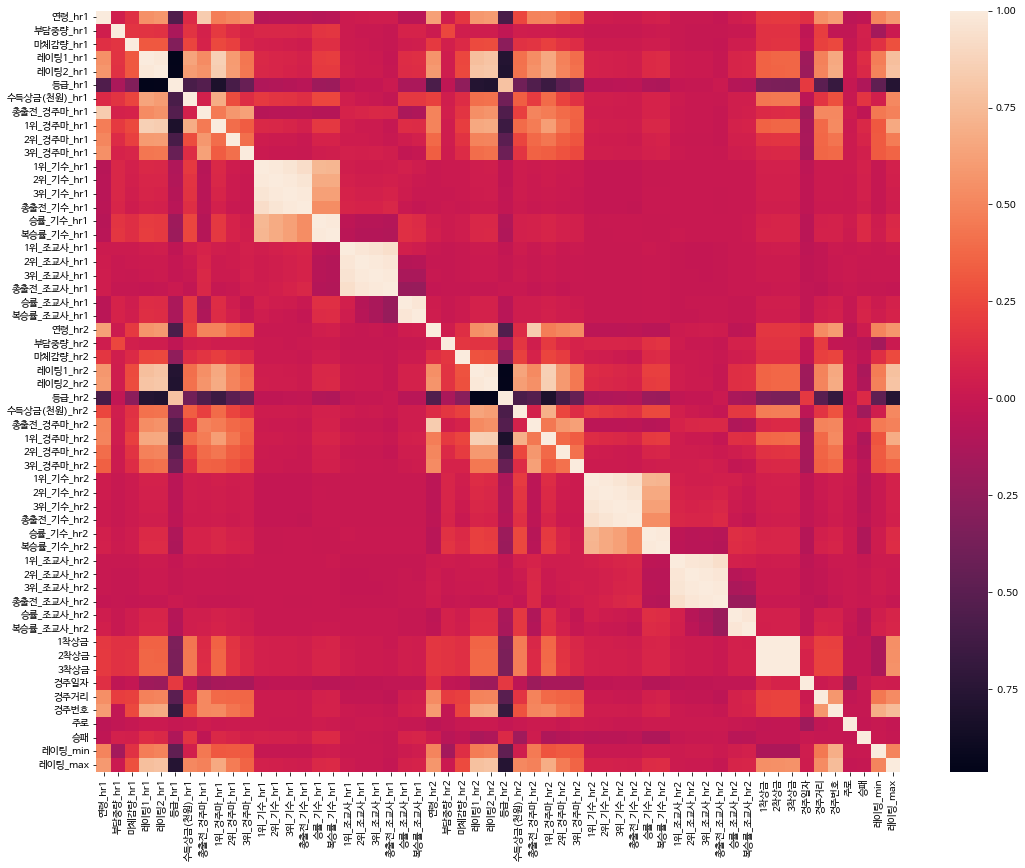

In [ ]:
plt.figure(figsize=(18,14))
sns.heatmap(vs_RDR.corr(), annot = False)
plt.show()

승패 feature과 관련이 큰 feature을 히트맵에서는 알아보기 힘드므로, 따로 corr을 계산해보자.

In [ ]:
corrWin = pd.DataFrame(vs_RDR.drop('승패', axis=1).corrwith(other = vs_RDR['승패']),columns=['corr']).sort_values(by='corr', ascending=False, key = lambda x : abs(x))
cm = sns.light_palette("red", as_cmap=True)
corrWin.style.background_gradient(cmap=cm).set_precision(2)

가설은 각각 체중, 성별, 마필생산국가, 연령, 등급과 관련 있으나,<br>
상관계수를 알 수 없는 feature을 제외하고 체중, 연령, 등급은 각각 상관계수의 절댓값의 평균이<br>
체중 : 0.045, 연령 : 0.035, 등급 : 0.11 정도로, 등급을 제외하면 그다지 선형관계가 없음을 알 수 있다.<br>
또한 수득상금, 레이팅, 기수의 승률(및 복승률), 경주마의 승리 횟수 등이 상관계수가 높음을 알 수 있다.

In [ ]:
vs_RDR.to_csv("vs_RDR.csv", index=False, encoding="utf-8-sig")

# 3. 모델링 및 모델 해석

In [ ]:
vs_RDR = pd.read_csv("/content/vs_RDR.csv")

In [ ]:
vs_RDR = vs_RDR.drop(["마명_hr1", "마명_hr2", '기수명_hr1', '기수명_hr2', '조교사명_hr1', '조교사명_hr2'], axis=1) 
#이름이 있으면 좋을 것 같지만, 범주가 너무 높아서 과적합의 위험이 있고 모델을 학습하는데 불필요하다.
#EDA 과정에 포함되었지만 추후 결과 비교를 위해 csv에는 반영하지 않았다.

In [ ]:
vs_RDR.tail()

연령_hr1  마명_hr1 기수명_hr1 마필생산국가_hr1 성별_hr1 조교사명_hr1  부담중량_hr1  마체감량_hr1  \
8258       5  문학엠파이어     김동수         미국      거      정호익      56.0     505.0   
8259       5  문학엠파이어     김동수         미국      거      정호익      56.0     505.0   
8260       5  문학엠파이어     김동수         미국      거      정호익      56.0     505.0   
8261       5  문학엠파이어     김동수         미국      거      정호익      56.0     505.0   
8262       5   티케이데이     박을운         한국      암      김동철      54.0     524.0   

      레이팅1_hr1  레이팅2_hr1  등급_hr1  수득상금(천원)_hr1 경매마 여부_hr1  총출전_경주마_hr1  \
8258        51        51       3          3925          N           24   
8259        51        51       3          3925          N           24   
8260        51        51       3          3925          N           24   
8261        51        51       3          3925          N           24   
8262        51        52       3          7086          N           30   

      1위_경주마_hr1  2위_경주마_hr1  3위_경주마_hr1  1위_기수_hr1  2위_기수_hr1  3위_기수_hr1  \
8258           2           0           3      284.0      298.0      325.0   
8259           2           0           3      284.0      298.0      325.0   
8260           2           0           3      284.0      298.0      325.0   
8261           2           0           3      284.0      298.0      325.0   
8262           1           6           4      457.0      442.0      389.0   

      총출전_기수_hr1  승률_기수_hr1  복승률_기수_hr1  1위_조교사_hr1  2위_조교사_hr1  3위_조교사_hr1  \
8258      3130.0        9.1        18.6       537.0       554.0       539.0   
8259      3130.0        9.1        18.6       537.0       554.0       539.0   
8260      3130.0        9.1        18.6       537.0       554.0       539.0   
8261      3130.0        9.1        18.6       537.0       554.0       539.0   
8262      3939.0       11.6        22.8        91.0       134.0       133.0   

      총출전_조교사_hr1  승률_조교사_hr1  복승률_조교사_hr1  연령_hr2  마명_hr2 기수명_hr2 마필생산국가_hr2  \
8258       5248.0        10.2         20.8       5    더트서퍼     박병윤         미국   
8259       5248.0        10.2         20.8       4    라이오넷     이현종         미국   
8260       5248.0        10.2         20.8       6    인천캡틴     임다빈         미국   
8261       5248.0        10.2         20.8       3  사려니퍼스트     이용호         한국   
8262       1584.0         5.7         14.2       5   엘리트라인     송재철         미국   

     성별_hr2 조교사명_hr2  부담중량_hr2  마체감량_hr2  레이팅1_hr2  레이팅2_hr2  등급_hr2  \
8258      거      유재길      56.0     476.0        41        42       4   
8259      암      서인석      54.0     472.0        36        36       4   
8260      수      정호익      55.0     496.0        62        62       3   
8261      수      이신영      54.0     482.0        71        60       2   
8262      수      이희영      56.0     515.0        50        46       4   

      수득상금(천원)_hr2 경매마 여부_hr2  총출전_경주마_hr2  1위_경주마_hr2  2위_경주마_hr2  \
8258          2624          N           25           2           0   
8259          1296          N           12           0           0   
8260         10548          N           12           2           2   
8261         16658          N           12           5           1   
8262          3638          N           24           1           1   

      3위_경주마_hr2  1위_기수_hr2  2위_기수_hr2  3위_기수_hr2  총출전_기수_hr2  승률_기수_hr2  \
8258           0      163.0      200.0      203.0      2692.0        6.1   
8259           1      191.0      164.0      190.0      1689.0       11.3   
8260           2       62.0       69.0       77.0       847.0        7.3   
8261           2       62.0       70.0       84.0      1045.0        5.9   
8262           3      277.0      313.0      319.0      3417.0        8.1   

      복승률_기수_hr2  1위_조교사_hr2  2위_조교사_hr2  3위_조교사_hr2  총출전_조교사_hr2  승률_조교사_hr2  \
8258        13.5       418.0       445.0       492.0       5775.0         7.2   
8259        21.0       446.0       480.0       472.0       4857.0         9.2   
8260        15.5       537.0       554.0       539.0       5248.0        10.2   
8261        12.6       347

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Test셋 분리 (경주일자 기준으로 최신 경기의 20%를 Test로 설정한다.)
s=vs_RDR.groupby('경주일자').ngroup()
s >= s.quantile(q=0.8)

Test=vs_RDR.loc[s >= s.quantile(q=0.8)].copy()
Train=vs_RDR.drop(Test.index)

In [ ]:
# Val셋 분리 (랜덤으로 20%)

X_train, X_val, y_train, y_val = train_test_split(Train.drop('승패', axis = 1),Train.승패, train_size= 0.8, random_state=42)
X_test, y_test = Test.drop('승패', axis = 1),Test.승패

In [ ]:
!pip install xgboost --upgrade
from xgboost import XGBClassifier
!pip install category_encoders
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
! pip install optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.6 MB 70 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 829 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 11.4 MB/s 
     |████████████████████████████████| 209 kB 95.3 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 147 kB 89.4 MB/s 
     |████████████████████████████████| 50 kB 7.9 MB/s 
     |████████████████████████████████| 112 kB 77.9 MB/s 
  Created wheel for pyperclip: filen

## baseline 모델 설정

최소한의 베이스라인은 '가장 현재 등급이 높은 말이 우승한다.'를 가정으로 만들어,<br>
베이스라인의 예측력을 넘는 어느정도 예측력이 있는 모델을 목표로 한다고 하자.<br>
즉, 이 이진분류 모델에서는 등급이 높은 말이 우승하는 것을 전제로 베이스라인을 설정한다.

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
Train.head()

연령_hr1 마필생산국가_hr1 성별_hr1  부담중량_hr1  마체감량_hr1  레이팅1_hr1  레이팅2_hr1  등급_hr1  \
0       3         한국      암      54.5     499.0        40        40       4   
1       3         한국      암      54.5     499.0        40        40       4   
2       3         한국      암      54.5     499.0        40        40       4   
3       3         한국      수      56.5     493.0         0         0       6   
4       3         한국      수      56.5     493.0         0         0       6   

   수득상금(천원)_hr1 경매마 여부_hr1  총출전_경주마_hr1  1위_경주마_hr1  2위_경주마_hr1  3위_경주마_hr1  \
0          4036          N           11           3           1           0   
1          4036          N           11           3           1           0   
2          4036          N           11           3           1           0   
3           644          N           18           0           0           2   
4           644          N           18           0           0           2   

   1위_기수_hr1  2위_기수_hr1  3위_기수_hr1  총출전_기수_hr1  승률_기수_hr1  복승률_기수_hr1  \
0       69.0      136.0      136.0      1742.0        4.0        11.8   
1       69.0      136.0      136.0      1742.0        4.0        11.8   
2       69.0      136.0      136.0      1742.0        4.0        11.8   
3      390.0      299.0      310.0      2787.0       14.0        24.7   
4      390.0      299.0      310.0      2787.0       14.0        24.7   

   1위_조교사_hr1  2위_조교사_hr1  3위_조교사_hr1  총출전_조교사_hr1  승률_조교사_hr1  복승률_조교사_hr1  \
0       320.0       380.0       395.0       4651.0         6.9         15.1   
1       320.0       380.0       395.0       4651.0         6.9         15.1   
2       320.0       380.0       395.0       4651.0         6.9         15.1   
3       460.0       384.0       335.0       3456.0        13.3         24.4   
4       460.0       384.0       335.0       3456.0        13.3         24.4   

   연령_hr2 마필생산국가_hr2 성별_hr2  부담중량_hr2  마체감량_hr2  레이팅1_hr2  레이팅2_hr2  등급_hr2  \
0       3         한국      수      56.5     493.0         0         0       6   
1       3         한국      암      54.5     483.0        37        37       4   
2       3         한국      수      56.5     484.0        53        54       3   
3       3         한국      암      54.5     483.0        37        37       4   
4       3         한국      수      56.5     484.0        53        54       3   

   수득상금(천원)_hr2 경매마 여부_hr2  총출전_경주마_hr2  1위_경주마_hr2  2위_경주마_hr2  3위_경주마_hr2  \
0           644          N           18           0           0           2   
1          2624          N           18           2           0           1   
2          7965          Y           17           2           4           3   
3          2624          N           18           2           0           1   
4          7965          Y           17           2           4           3   

   1위_기수_hr2  2위_기수_hr2  3위_기수_hr2  총출전_기수_hr2  승률_기수_hr2  복승률_기수_hr2  \
0      390.0      299.0      310.0      2787.0       14.0        24.7   
1      413.0      375.0      367.0      4462.0        9.3        17.7   
2      457.0      442.0      389.0      3939.0       11.6        22.8   
3      413.0      375.0      367.0      4462.0        9.3        17.7   
4      457.0      442.0      389.0      3939.0       11.6        22.8   

   1위_조교사_hr2  2위_조교사_hr2  3위_조교사_hr2  총출전_조교사_hr2  승률_조교사_hr2  복승률_조교사_hr2  \
0       460.0       384.0       335.0       3456.0        13.3         24.4   
1         8.0        18.0        23.0        353.0         2.3          7.4   
2        85.0        83.0        62.0        722.0        11.8         23.3   
3         8.0        18.0        23.0        353.0         2.3          7.4   
4        85.0        83.0        62.0        722.0        11.8         23.3   

  부담구분       1착상금       2착상금       3착상금      경주일자    경주거리  경주번호    주로  날씨  \
0  별정A  8800000.0  5500000.0  3740000.0  20210108  1000.0     1  0.09  맑음   
1  별정A  8800000.0  5500000.0  3740000.0  20210108  1000.0     1  0.09  맑음   
2  별정A  8800000.0  5500000.0  3740000.0  202

In [ ]:
baseline = Test['등급_hr1'] <= Test['등급_hr2']
round((Test.승패==baseline).sum()/len(Test.승패),3)

0.611

기준모델의 정확도가 약 0.611로 나온 것을 알 수 있다.<br>
따라서 test를 기준으로 0.611 이상의 accuracy를 만족하는 모델을 만들자.

## 모델링

In [ ]:
OrdinalMap = [
              {'col': '성별_hr1', 
               'mapping': {'수': 3, '거': 2, '암': 1}},
              {'col': '성별_hr2', 
               'mapping': {'수': 3, '거': 2, '암': 1}},
              {'col': '경매마 여부_hr1', 
               'mapping': {'Y': 1, 'N': 0}},
              {'col': '경매마 여부_hr2', 
               'mapping': {'Y': 1, 'N': 0}},
              {'col': '부담구분', 
               'mapping': {'핸디캡': 4, '별정A': 3, '별정B': 2, '마령': 1}},
              {'col': '날씨', 
               'mapping': {'맑음': 5, '흐림': 4, '안개':3, '비': 2, '눈':1}}
             ]

pipe = make_pipeline(
    OrdinalEncoder(mapping = OrdinalMap),
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent')
)
X_train_data = pipe.fit_transform(X_train)
X_train = pd.DataFrame(X_train_data, columns = X_train.columns)
X_val_data = pipe.transform(X_val)
X_val = pd.DataFrame(X_val_data, columns = X_val.columns)
X_test_data = pipe.transform(X_test)
X_test = pd.DataFrame(X_test_data, columns = X_test.columns)

In [ ]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
xgb = XGBClassifier()
param = {
        "random_state" : [2],
        "n_estimators" : [10000],
        "learning_rate" : [0.00001],
        "max_depth" : randint(4, 6),
        #"tree_method" : ['gpu_hist'],
        #'predictor' : ['gpu_predictor'],
          'early_stopping_rounds' : [120],
          'eval_metric' : ['error'],
          'objective' : ['binary:logistic'],
          'gamma': uniform(1.5, 2.5),
          'eta':uniform(0.05, 0.1),
          'colsample_bytree' : uniform(0.2, 0.9),
          'min_child_weight' : uniform(3, 4)
        }

clf = RandomizedSearchCV(xgb, param_distributions=param, n_iter=100, cv=8,scoring='roc_auc')
eval_set = [(X_train, y_train), (X_val, y_val)]
clf.fit(X_train, y_train, eval_set =eval_set, verbose=False)


In [ ]:
xgb = clf.best_estimator_

In [ ]:
print(xgb.score(X_train, y_train))
print(xgb.score(X_val, y_val))
print(xgb.score(X_test, y_test))

0.705234864968642
0.6918351676478116
0.6952439273321086


In [ ]:
from sklearn.metrics import *
y_test_pred = xgb.predict(X_test)

In [ ]:
print(xgb.score(X_test, y_test))

0.6952439273321086


In [ ]:
precision_score(y_test, y_test_pred)

0.7007413187670698

In [ ]:
recall_score(y_test, y_test_pred)

0.7121332275971451

In [ ]:
classification_report(y_test, y_test_pred, output_dict=True)['accuracy']

0.6952439273321086

baseline의 성능(0.611)보다 성능이 좋은 것을 알 수 있다.

In [ ]:
import joblib

joblib.dump(xgb, 'xgbmodel.pkl');

## 지난주차 순위 예측

In [ ]:
vs_RDR_withName = pd.read_csv("/content/vs_RDR.csv")

In [ ]:
Testing = vs_RDR_withName[(vs_RDR_withName.경주일자 == max(vs_RDR_withName.경주일자)) & (vs_RDR_withName.경주번호 == 1) ]

In [ ]:
Testing_Name = Testing[["마명_hr1", "마명_hr2", '기수명_hr1', '기수명_hr2', '조교사명_hr1', '조교사명_hr2']]

In [ ]:
Testing = Testing.drop(Testing_Name.columns, axis=1) 

In [ ]:
X_testing, y_testing = Testing.drop('승패', axis = 1),Testing.승패

In [ ]:
X_testing = pipe.transform(X_testing)


In [ ]:
X_testing = pd.DataFrame(X_testing, columns=Testing.drop('승패', axis = 1).columns)

In [ ]:
xgb.score(X_testing, y_testing)

0.8727272727272727

In [ ]:
Testing_withProba =pd.concat([pd.DataFrame(xgb.predict_proba(X_testing), columns=['hr2_win','hr1_win']), Testing_Name.reset_index(drop=True)],axis=1).drop(['기수명_hr1', '기수명_hr2', '조교사명_hr1', '조교사명_hr2'], axis=1) 

In [ ]:
Testing_withProba.head()

hr2_win   hr1_win 마명_hr1 마명_hr2
0  0.500199  0.499801   드림투어  섬싱로스트
1  0.500078  0.499922   드림투어   스트렝스
2  0.500006  0.499994   드림투어  선더갤러퍼
3  0.500033  0.499967   드림투어  바로챔피언
4  0.500078  0.499922   드림투어  찬란한불꽃

In [ ]:
Testing_withProba.groupby('마명_hr1')['hr1_win'].sum()

마명_hr1
대박삭스     1.500187
드림투어     4.999188
마이티쎈     0.499985
바로챔피언    2.999859
선더갤러퍼    3.499583
섬싱로스트    4.501077
스트렝스     4.000203
업타운위즈    1.000197
점순이고     2.000214
찬란한불꽃    2.499953
Name: hr1_win, dtype: float32

In [ ]:
Testing_withProba.groupby('마명_hr2')['hr2_win'].sum()

마명_hr2
대박삭스      3.500436
마이티쎈      4.499306
바로챔피언     1.999825
선더갤러퍼     1.499767
섬싱로스트     0.500199
스트렝스      0.999953
업타운위즈     4.000185
점순이고      3.000297
찬란한불꽃     2.500026
케이엔스타트    4.999561
Name: hr2_win, dtype: float32

In [ ]:
Testing_hr1 = pd.DataFrame({'sumProb1' : Testing_withProba.groupby('마명_hr1')['hr1_win'].sum()}).reset_index().set_index('마명_hr1').rename_axis(index='마명')
Testing_hr1

sumProb1
마명             
대박삭스   1.500187
드림투어   4.999188
마이티쎈   0.499985
바로챔피언  2.999859
선더갤러퍼  3.499583
섬싱로스트  4.501077
스트렝스   4.000203
업타운위즈  1.000197
점순이고   2.000214
찬란한불꽃  2.499953

In [ ]:
Testing_hr2 = pd.DataFrame({'sumProb2' : Testing_withProba.groupby('마명_hr2')['hr2_win'].sum()}).reset_index().set_index('마명_hr2').rename_axis(index='마명')
Testing_hr2

sumProb2
마명              
대박삭스    3.500436
마이티쎈    4.499306
바로챔피언   1.999825
선더갤러퍼   1.499767
섬싱로스트   0.500199
스트렝스    0.999953
업타운위즈   4.000185
점순이고    3.000297
찬란한불꽃   2.500026
케이엔스타트  4.999561

In [ ]:
Testing_hrs = pd.concat([Testing_hr1, Testing_hr2], axis=1).fillna(0)
Testing_hrs['sumProb'] = Testing_hrs['sumProb1']+Testing_hrs['sumProb2']
Testing_hrs = Testing_hrs.drop(['sumProb1', 'sumProb2'], axis=1)
Testing_hrs.sort_values(by='sumProb', ascending=False)

sumProb
마명              
섬싱로스트   5.001276
대박삭스    5.000624
점순이고    5.000511
업타운위즈   5.000383
스트렝스    5.000156
찬란한불꽃   4.999978
바로챔피언   4.999684
케이엔스타트  4.999561
선더갤러퍼   4.999349
마이티쎈    4.999291
드림투어    4.999188

In [ ]:
RaceDetailResult[(RaceDetailResult.경주일자 == "2022-11-27") & (RaceDetailResult.경주번호 == 1) ][['마명', '순위']].sort_values(by='순위')

마명  순위
9321   섬싱로스트   1
9322    점순이고   2
9323    대박삭스   3
9324    스트렝스   4
9325   업타운위즈   5
9326   찬란한불꽃   6
9327    마이티쎈   7
9328   선더갤러퍼   8
9329   바로챔피언  10
9330  케이엔스타트  11
9331    드림투어  12

## 모델 분석

In [ ]:
import joblib
xgb = joblib.load("/content/xgbmodel.pkl")


### Feature Importances

In [ ]:
plt.rc('font', family='NanumBarunGothic')

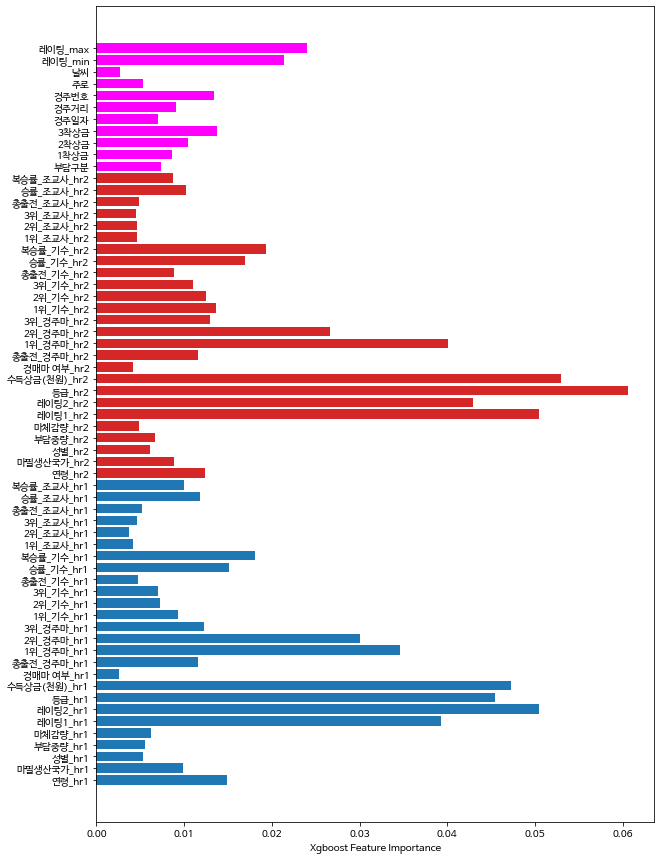

In [ ]:
FM = xgb.feature_importances_
plt.figure(figsize=(10,15))
colors = ['tab:red' if '_hr2' in c else ('tab:blue' if '_hr1' in c else 'fuchsia') for c in X_val.columns]
plt.barh(X_val.columns, FM, color=colors)
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [ ]:
FM_df = pd.DataFrame([X_val.columns, FM], index=['Feature', 'Importances']).T

In [ ]:
race_impt = FM_df[FM_df.Feature.apply(lambda x: '_hr' not in x)]
hr1_impt = FM_df[FM_df.Feature.apply(lambda x: '_hr1' in x)]
hr2_impt = FM_df[FM_df.Feature.apply(lambda x: '_hr2' in x)]

In [ ]:
hrs_impt_mean = pd.DataFrame({'Importances' : (hr1_impt.Importances.reset_index(drop=True)+hr2_impt.Importances.reset_index(drop=True))/2,
                              'Feature' : hr1_impt.Feature.apply(lambda x: x.replace("_hr1",''))})
hr1_impt.Feature = list(hrs_impt_mean.Feature)
hr2_impt.Feature = list(hrs_impt_mean.Feature)

In [ ]:
import seaborn as sns

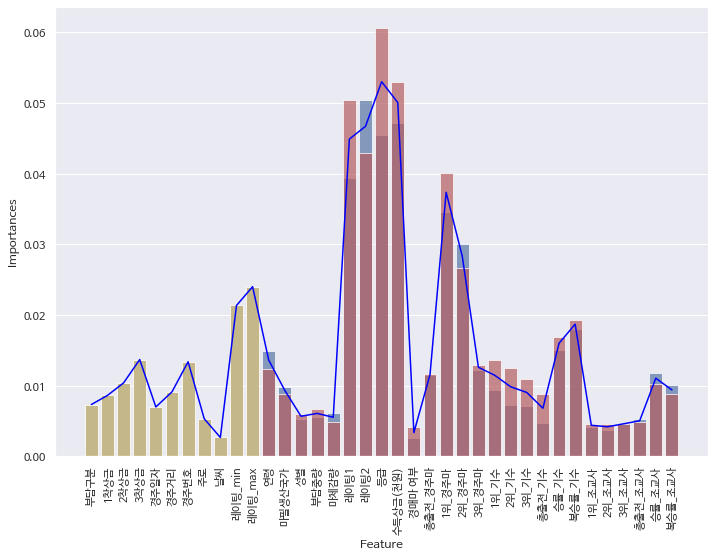

In [ ]:
sns.set(rc={'axes.facecolor':'whitesmoke'})
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.rc('font', family='NanumBarunGothic')

ax=plt.subplots()
colors = {s : 'y' if s in list(race_impt.Feature) else 'b'  for s in pd.concat([race_impt, hr1_impt]).Feature}
ax=sns.barplot(data = pd.concat([race_impt, hr1_impt]), x = 'Feature', y = "Importances",palette = colors, alpha = 0.7)
colors = {s : 'y' if s in list(race_impt.Feature) else 'r'  for s in pd.concat([race_impt, hr1_impt]).Feature}
ax=sns.barplot(data = pd.concat([race_impt, hr2_impt]), x = 'Feature', y = "Importances",palette = colors, alpha = 0.7)
ax=sns.lineplot(data = pd.concat([race_impt, hrs_impt_mean]), x = 'Feature', y = "Importances",color = 'blue')
ax.tick_params(axis='x', rotation=90)


Feature Importance로 확인하면 말의 등급, 수득상금, 레이팅, 1,2위 횟수가 가장 중요하고, <br>
기수의 승률, 조교사의 승률이 그 뒤를 이었다.<br>
의외로 경기 일자나 날씨 등의 경기 상황은 별다른 중요도가 아니다.<br>
이는, 경기 상황은 자신의 말과 상대의 말의 동등하게 갖춰지기 때문으로 해석할 수 있다.

### Permutation Importance

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
perm = PermutationImportance(xgb, scoring = "accuracy", n_iter=50, random_state=42).fit(X_val, y_val)
eli5.show_weights(perm, top = 80, feature_names = X_test.columns.tolist())

Permutation Importance에서는 말의 수득상금, 레이팅, 등급, 1,2위 횟수 순별로 가장 중요하다.<br>
순별은 다르지만 말의 성적이 가장 큰 비중을 차지하고,<br>
기수의 승률, 조교사의 승률이 그 다음인 것은 Feature Importance와 비슷하다고 볼 수 있다.

### PDP Plot(isolated)

In [ ]:
!pip install pdpbox
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 136.3 MB/s 
     |████████████████████████████████| 37.8 MB 141.9 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=6db60d7b7eea78cbce8dd20f8f3590e43c57d34101c1b06f5e4dba31a1394273
  Stored in directory: /root/.cache/pip/wheels/35/fb/ef/a08dd2a1611435285fa3f9d9104bf554f10c2eb7293b526ccb
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp38-cp38-linux_x86_64.whl size=11152118 sha256=817dd3f49146dc310825fa2e266ada29fa9c43897bc4c7ac42747b3fa27307c3
  Stored in directory: /root/.cache/pip/wheels/85/86/f1/054e7477b5e68f3c4a1258d12ae1c2205d6889283ce631dfe5
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=7a66d535b5e92924579e7a1f3f4913f86bfdc36d6de23f500885f6c549623154
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.0 MB/s 


In [ ]:
!MaskFPUExceptions(True)

/bin/bash: -c: line 0: syntax error near unexpected token `True'
/bin/bash: -c: line 0: `MaskFPUExceptions(True)'


In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap
from IPython.display import display
from ipywidgets import interact

In [ ]:
import os
import sys
sys.stderr = open(os.devnull, "w")
sys.stderr = sys.__stderr__ #한글 폰트 에러 중지

In [ ]:
def isolated_pdp_plot(feature):
  isolated = pdp_isolate(
      model=xgb, 
      dataset=X_val, 
      model_features=X_val.columns, 
      feature=feature,
      grid_type='percentile', # default='percentile', or 'equal'
  )
  pdp_plot(isolated, feature_name=feature, figsize=(12,7))
  plt.show();
  return
interact(isolated_pdp_plot, feature = sorted(list(X_val.columns)));


interactive(children=(Dropdown(description='feature', options=('1위_경주마_hr1', '1위_경주마_hr2', '1위_기수_hr1', '1위_기수…

In [ ]:
display(pd.DataFrame(pipe['ordinalencoder-1'].mapping))
display(pd.DataFrame(pipe['ordinalencoder-2'].mapping))

col                                      mapping
0      성별_hr1                     {'수': 3, '거': 2, '암': 1}
1      성별_hr2                     {'수': 3, '거': 2, '암': 1}
2  경매마 여부_hr1                             {'Y': 1, 'N': 0}
3  경매마 여부_hr2                             {'Y': 1, 'N': 0}
4        부담구분      {'핸디캡': 4, '별정A': 3, '별정B': 2, '마령': 1}
5          날씨  {'맑음': 5, '흐림': 4, '안개': 3, '비': 2, '눈': 1}

col                                            mapping data_type
0  마필생산국가_hr1  한국      1
미국      2
뉴질랜드    3
호주      4
캐나다   ...    object
1  마필생산국가_hr2  한국      1
미국      2
캐나다     3
뉴질랜드    4
호주    ...    object

#### 가설 해결

**가설**

*   경주마의 체중이 가벼울수록 승률이 높아진다.
*   수컷인 경우 암말과 거세한 말에 비해 승률이 높아진다.
*   국산마보다 외산마가 더 승률이 높다.
*   나이가 어릴수록 승률이 높아진다.
*   품평회에서 좋은 성적을 얻을수록 승률이 높아진다.


##### 경주마의 체중이 가벼울수록 승률이 높아진다.

<img align="left" src="https://drive.google.com/uc?export=view&id=1PztBNwNYiuezgFeqSvx4Ehu1HS-v5gJI" width=500>
<img align="right" src="https://drive.google.com/uc?export=view&id=179nlcFHjfjKM5fIJemdV5YgdOdSs2UwV" width=500>

왼쪽 그래프에서는 hr1(자신의 말)의 체중이 증가할수록, 아주 약간씩 승리할 확률(1로 분류될 확률)이 커지지만 전체적으로는 영향이 매우 적음을 알 수 있다.<br>
오른쪽 그래프는 hr2(상대방의 말)의 체중이 500 이하까지는 증가할수록, 승리할 확률(1로 분류될 확률)이 감소하고,<br>
500이상에서 증가할수록, 승리할 확률(1로 분류될 확률)이 커지지만<br>
400~ 550 구간의 평균적인 구간을 제외하고 전체적으로는 그렇게 큰 영향이 없음을 알 수 있다.

왜 hr2의 체중 그래프가 평균 부분에서 꺾였는지는 Shpa그래프에서 hr1의 체중 그래프와 비교해 보면, hr2의 양 끝 부분이 상대적으로 feature의 영향력이 커지기 때문으로 알 수 있다.

따라서 전체적으로 보면, 경주마의 체중은 승패와 관련이 거의 없다고 볼 수 있다.
따라서 가설이 타당하다고 할 수 없다.

##### 수컷인 경우 암말과 거세한 말에 비해 승률이 높아진다.

<img align="left" src="https://drive.google.com/uc?export=view&id=1aCK4ijg9ls-q49Jv84hjLwrP31PQy5Hu" width=500>
<img align="right" src="https://drive.google.com/uc?export=view&id=1n3CuZzh5QUD3zHW1L_AspuPKAgX7ixaR" width=500>

In [ ]:
display(pd.DataFrame(pipe['ordinalencoder-1'].mapping).iloc[[0,1]])

col                   mapping
0  성별_hr1  {'수': 3, '거': 2, '암': 1}
1  성별_hr2  {'수': 3, '거': 2, '암': 1}

ordinalencoder을 적용시킬 때, 수컷:3, 거세:2, 암컷:1로 설정하였다.

왼쪽 그래프에서 3에 가까울수록 그래프가 증가한다.<br>
즉, 자신의 말이 3에 가까울수록 승률이 높아짐을 알 수 있다.<br>
또한 오른쪽 그래프에서 3에 가까울수록 그래프가 감소한다.<br>
따라서 상대방의 말이 3에 가까울수록 승률이 감소함을 알 수 있다. <br>
즉, 수컷이 가장 승률이 높고, 거세된 말이 그 다음, 암컷은 가장 승률이 낮다고 할 수 있다.
따라서 가설이 타당하다고 할 수 있다.

##### 국산마보다 외산마가 더 승률이 높다.

<img align="left" src="https://drive.google.com/uc?export=view&id=1NgyjECTcEqPj4x9mhfNUOFMVQXLvlS_s" width=500>
<img align="right" src="https://drive.google.com/uc?export=view&id=1h7-CLmN9rS46WFkM0cmfs0x0MGXRDYbe" width=500>

In [ ]:
display(pd.DataFrame(pipe['ordinalencoder-2'].mapping)[['col', 'mapping']])

col                                            mapping
0  마필생산국가_hr1  한국      1
미국      2
뉴질랜드    3
호주      4
캐나다   ...
1  마필생산국가_hr2  한국      1
미국      2
캐나다     3
뉴질랜드    4
호주    ...

ordinalencoder을 적용시킬 때, 국산마:1, 이외의 번호는 외산마로 설정하였다.

왼쪽 그래프에서 h1이 국산마일때보다 외산마일때 승률이 낮아짐을 알 수 있다.<br>
오른쪽 그래프에서 h2가 국산마일때보다 외산마일때 승률이 낮아짐을 알 수 있다.<br>
따라서 자신의 말이 국산마이고 상대방의 말이 국산마일때 승률이 가장 높고,
자신의 말이 외산마이고 상대방의 말이 외산마이면 승률이 떨어짐을 알 수 있다.<br>
따라서 가설이 타당하다고 할 수 없다.

##### 나이가 어릴수록 승률이 높아진다.

<img align="left" src="https://drive.google.com/uc?export=view&id=1FM5Etq-U_2E2snJmGYeovNjSUCVl98y7" width=500>
<img align="right" src="https://drive.google.com/uc?export=view&id=19zFcni0FB2YkEs_gJKxr0i5YCdwhlJi0" width=500>

왼쪽 그래프에서 h1이 나이들수록 승률이 낮아짐을 알 수 있다.<br>
오른쪽 그래프에서 h2가 나이들수록 승률이 낮아짐을 알 수 있다.

따라서 자신의 말과 상대방의 말이 나이가 적다면 승률이 높아지고, 자신의 말과 상대방의 말이 나이가 많다면 승률이 떨어짐을 알 수 있다.<br>
따라서 가설이 타당성을 검증할 수 없다.

##### 등급이 높을수록 (품평회에서 좋은 성적을 얻을수록) 승률이 높아진다.

<img align="left" src="https://drive.google.com/uc?export=view&id=18b1W97QGEPJ4_hJkiLf1_vuZRy-7-wGc" width=500>
<img align="right" src="https://drive.google.com/uc?export=view&id=15Juou9cv8Uz4vII-PiOYa2PmxpwhvRA9" width=500>

왼쪽 그래프에서 h1의 등급의 수치가 클수록 승률이 낮아짐을 알 수 있다.<br>
오른쪽 그래프에서 h2의 등급의 수치가 클수록 승률이 높아짐을 알 수 있다.

등급이 높을수록 등급의 수치가 적으므로, 등급이 높을수록 승률이 높아진다고 할 수 있다.<br>
따라서 가설이 옳다고 할 수 있다.

### PDP Plot(interact)

In [ ]:
from itertools import combinations
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [ ]:
features = sorted(list(X_val.columns))

def interact_pdp_plot(Feature_A, Feature_B):
  try:
    features = [Feature_A, Feature_B]
    interact = pdp_interact(
        model=xgb, 
        dataset=X_val, 
        model_features=X_val.columns, 
        features=features
    )
    pdp_interact_plot(interact,feature_names=features)
    plt.show();
    return
  except:
    print("서로 다른 Feature을 선택하십시오")
interact(interact_pdp_plot, Feature_A=features, Feature_B=features)

interactive(children=(Dropdown(description='Feature_A', options=('1위_경주마_hr1', '1위_경주마_hr2', '1위_기수_hr1', '1위_…

<function __main__.interact_pdp_plot(Feature_A, Feature_B)>

### Shap 그래프

In [ ]:
import shap

row = X_test.sample(n=300, random_state=42)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

x축은 각 데이터의 관측치를, 나타내며 빨간색은 예측에 긍정적인 영향을, 파란색은 부정적인 영향을 끼친다.<br>
전체적으로 파란색 부분과 빨간색 부분의 크기가 비슷한걸 보면,<br> 300개의 샘플에 긍정적인 영향을 주는 feature과 부정적인 영향을 주는 feature의 영향이 비슷함을 알 수 있다.

In [ ]:
display(pd.DataFrame(pipe['ordinalencoder-1'].mapping).iloc[[5]])

col                                      mapping
5  날씨  {'맑음': 5, '흐림': 4, '안개': 3, '비': 2, '눈': 1}

특히 날씨를 x축으로 맞출 경우,<br>

날씨의 값이 커질수록(날씨가 맑을수록) feature이 주는 영향력의 합이 커진다는 것은 흥미롭다.

### Shap Summary Plot

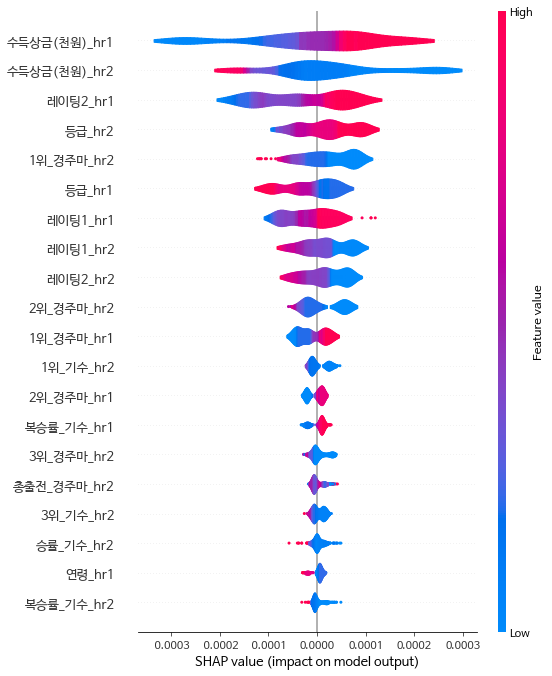

In [ ]:
shap_values = explainer.shap_values(X_test.sample(n=300, random_state=42))
shap.summary_plot(shap_values, X_test.sample(n=300, random_state=42), plot_type="violin")

In [ ]:
row = X_test.sample(n=300, random_state=42)
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))


pros = shaps.sort_values(ascending=False)[:5].index
cons = shaps.sort_values(ascending=True)[:5].index

In [ ]:
print('승리할 예측에 대한 Positive 요인 Top 5:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Negative 요인 Top 5:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

승리할 예측에 대한 Positive 요인 Top 5:
1. 수득상금(천원)_hr1 : 10560.0
2. 등급_hr2 : 5.0
3. 1위_경주마_hr2 : 1.0
4. 레이팅2_hr2 : 30.0
5. 1위_기수_hr2 : 14.0


Negative 요인 Top 5:
1. 수득상금(천원)_hr2 : 11550.0
2. 등급_hr1 : 5.0
3. 레이팅1_hr1 : 32.0
4. 레이팅2_hr1 : 31.0
5. 2위_경주마_hr1 : 0.0


## 인사이트 도출

경마에서 이기기 위해서는 경기
